<a href="https://colab.research.google.com/github/stevwhi/tarbela-forecast/blob/main/Tarbela.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikeras

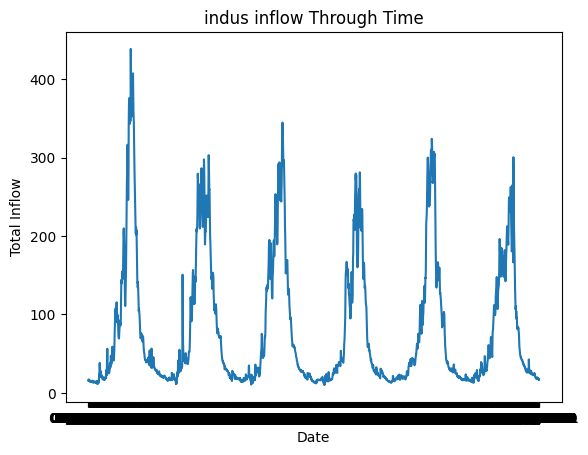

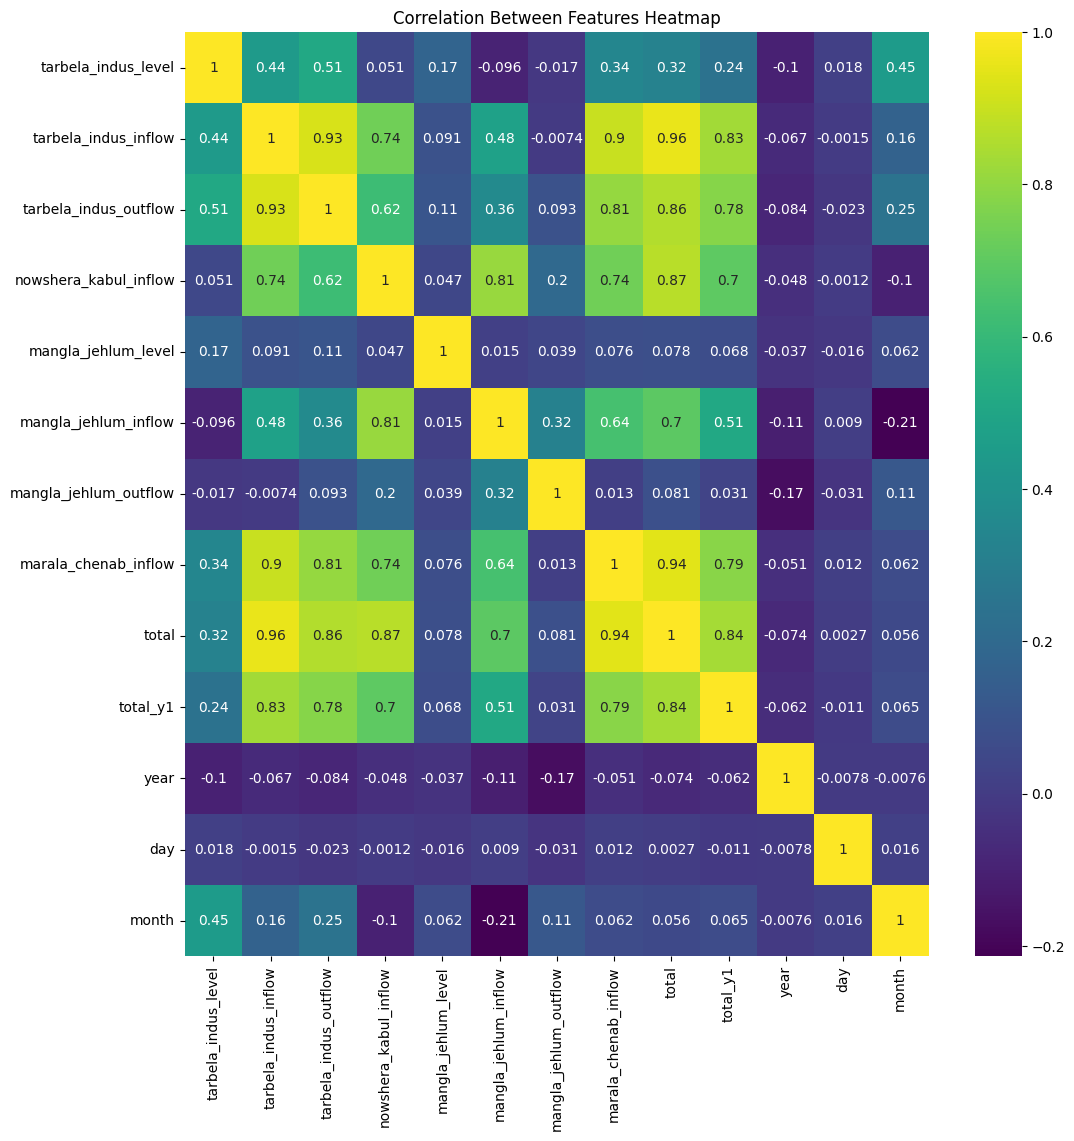

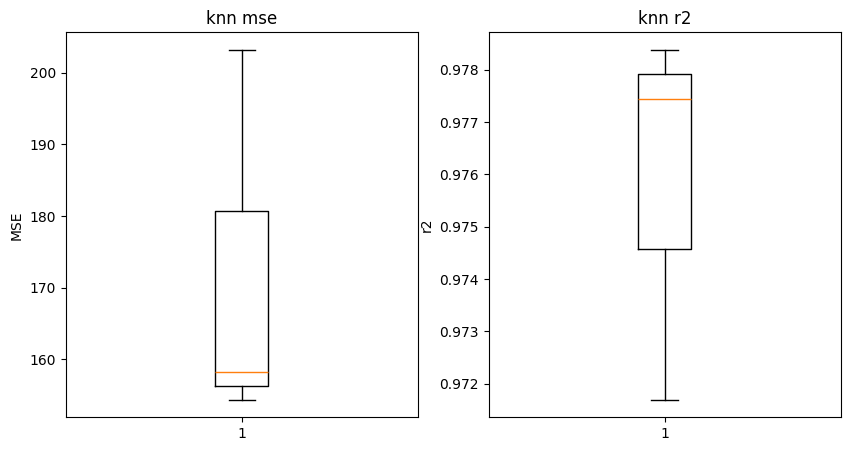

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

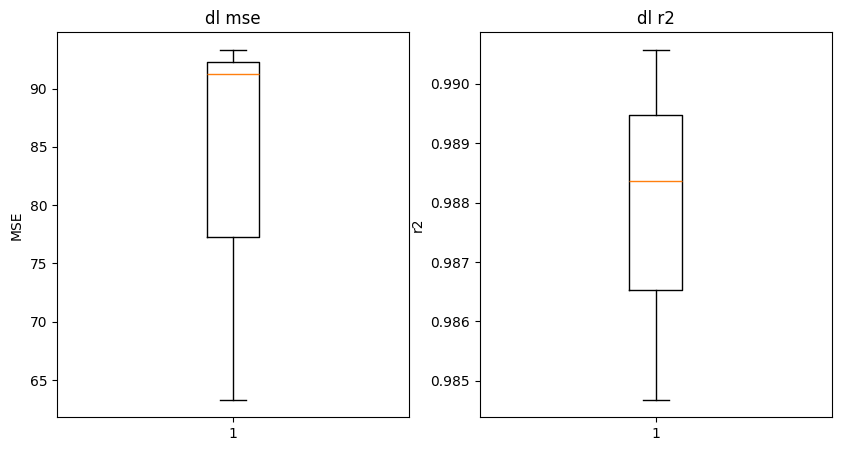

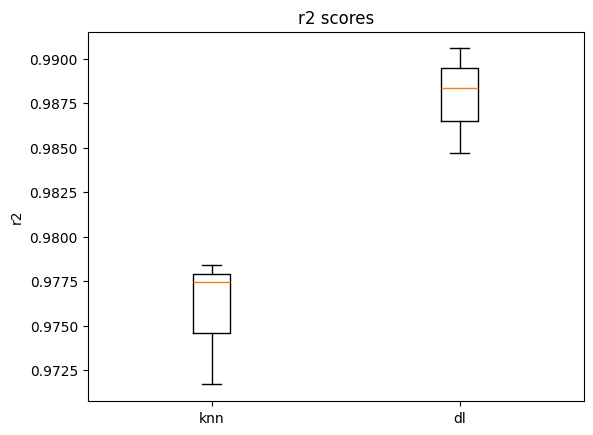

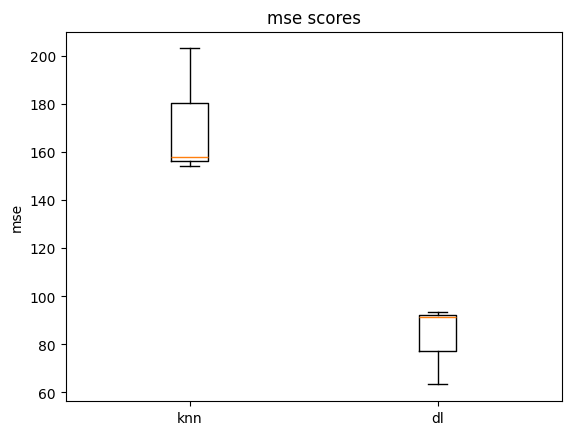

In [3]:
import pandas as pd

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#Import Dataset-----------------------------------------------------------------
dataset = pd.read_csv('/content/drive/MyDrive/Uni/y3/AI/pakistan-dams-inflow.csv')

#PP and EDA---------------------------------------------------------------------

#EDA: line graph
plt.figure()
plt.plot(dataset['Date'], dataset['tarbela_indus_inflow'])
plt.xlabel('Date')
plt.title('indus inflow Through Time')
plt.ylabel('Total Inflow')
plt.show()


#PP: date components
dataset['Date'] = pd.to_datetime(dataset['Date'], format='%d/%m/%Y')
dataset['year'] = dataset['Date'].dt.year
dataset['day'] = dataset['Date'].dt.day
dataset['month'] = dataset['Date'].dt.month
dataset = dataset.drop('Date', axis=1)

#EDA: heatmap
plt.figure(figsize=(12,12))
plt.title('Correlation Between Features Heatmap')
sns.heatmap(dataset.corr(numeric_only=True), annot=True, cmap='viridis')
plt.show()

#PP: non-numeric values
dataset = dataset.apply(pd.to_numeric, errors='coerce')
meansOfColumns = dataset.mean(numeric_only=True)
dataset = dataset.fillna(meansOfColumns)
if dataset.isnull().values.any():
    raise ValueError("oh no an NaN!")

#PP: normalize
standScale = StandardScaler()
X = standScale.fit_transform(dataset.drop('tarbela_indus_inflow', axis=1))
y = dataset['tarbela_indus_inflow']


#Model Implementation-----------------------------------------------------------
kf = KFold(n_splits=3, shuffle=True, random_state=0)

#knn
knnModel = KNeighborsRegressor(n_neighbors=10)
knnNMSE = cross_val_score(knnModel, X, y, cv=kf, scoring='neg_mean_squared_error')
knnMSE = -knnNMSE
knnR2 = cross_val_score(knnModel, X, y, cv=kf, scoring='r2')

#knn results
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.boxplot(knnMSE)
plt.title('knn mse')
plt.ylabel('MSE')

plt.subplot(1, 2, 2)
plt.ylabel('r2')
plt.boxplot(knnR2)
plt.title('knn r2')
plt.show()


#deep Learning
def createDL():
    dlModel = Sequential()
    dlModel.add(Dense(32, input_dim=X.shape[1], activation='relu'))
    dlModel.add(Dropout(0.2))
    dlModel.add(Dense(1))
    dlModel.compile(optimizer='adam', loss='mse')
    return dlModel
wrappedDL = KerasRegressor(model=createDL, epochs=250, verbose=0)
dlNMSE = cross_val_score(wrappedDL, X, y, cv=kf, scoring='neg_mean_squared_error')
dlMSE = -dlNMSE
dlR2 = cross_val_score(wrappedDL, X, y, cv=kf, scoring='r2')

#deep learning results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.boxplot(dlMSE)
plt.ylabel('MSE')
plt.title('dl mse')


plt.subplot(1, 2, 2)
plt.boxplot(dlR2)
plt.title('dl r2')
plt.ylabel('r2')
plt.show()



#Results Comparision------------------------------------------------------------

#r2
plt.figure()
plt.boxplot([knnR2, dlR2], labels=['knn', 'dl'])
plt.title('r2 scores')
plt.ylabel('r2')

#mse
plt.figure()
plt.boxplot([knnMSE, dlMSE], labels=['knn', 'dl'])
plt.title('mse scores')
plt.ylabel('mse')
plt.show()


